In [61]:
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing and Cleaning

In [62]:
from pathlib import Path
import imghdr
import os

data_dir = "Plant Disease Recognition Dataset"
image_extensions = [".png", ".jpg"]  # add all your image file extensions here

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        if filepath.exists():  # Check if the file exists before opening it
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
                os.remove(filepath)
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
                os.remove(filepath)
        else:
            print(f"{filepath} does not exist.")

# Data Loading and Splitting

In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (224, 224)
batch_size = 32

# Load your dataset using ImageDataGenerator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Disease Recognition Dataset/Train",
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Disease Recognition Dataset/Validation",
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical',
)

Found 1322 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


In [64]:
class_names = train_ds.class_names

# Count the number of samples per class in the training set
for class_name in class_names:
    num_samples = len([filename for filename in train_ds.file_paths if class_name in filename])
    print(f"Number of {class_name} samples in the training set: {num_samples}")

print()

# Count the number of samples per class in the validation set
for class_name in class_names:
    num_samples = len([filename for filename in val_ds.file_paths if class_name in filename])
    print(f"Number of {class_name} samples in the validation set: {num_samples}")

Number of Healthy samples in the training set: 458
Number of Powdery samples in the training set: 430
Number of Rust samples in the training set: 434

Number of Healthy samples in the validation set: 20
Number of Powdery samples in the validation set: 20
Number of Rust samples in the validation set: 20


# Visualization of Training Data

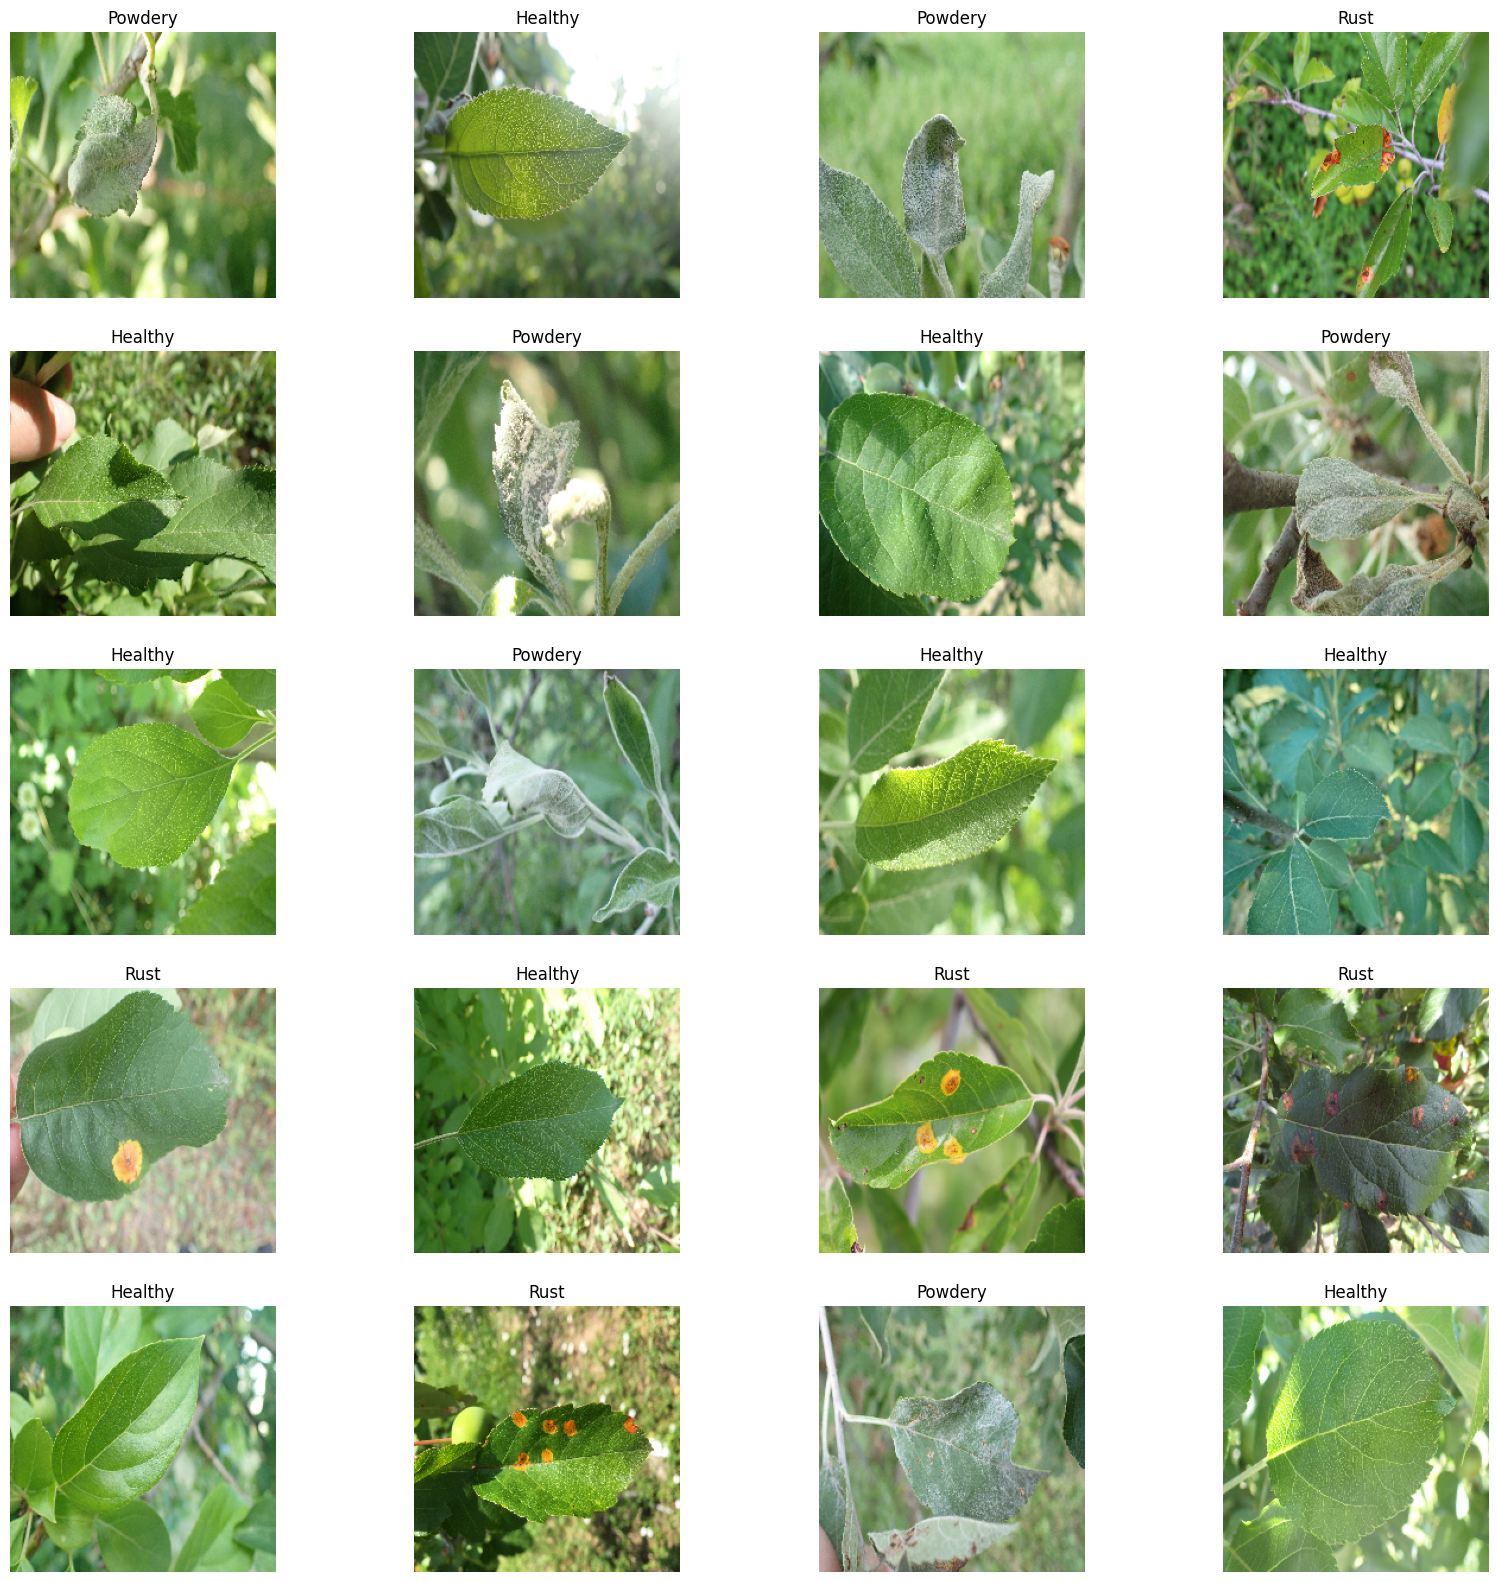

In [65]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")
plt.show()

# Model Architecture

Adding max pooling layers helps reduce the spatial dimensions and control overfitting.

In [66]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load ResNet50 as a base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained base model
base_model.trainable = False

# Create your custom model
inputs = tf.keras.Input(shape=(224, 224, 3))
resnet_input = preprocess_input(inputs)

# Include the output of the ResNet50 base model
base_model_output = base_model(resnet_input)

# Global average pooling
x = layers.GlobalAveragePooling2D()(base_model_output)

# Additional dense layers
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)

# Output layer
outputs = layers.Dense(3, activation="softmax")(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Print the model summary
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

# Visualizing Model Architecture

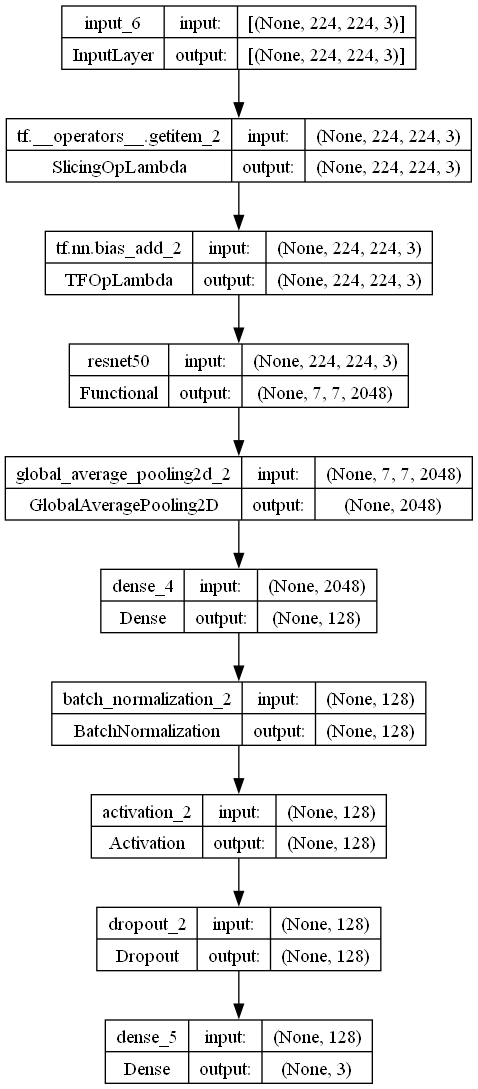

In [67]:
tf.keras.utils.plot_model(model, to_file='model_archi_08_copy.png', show_shapes=True)

# Display Model Summary

In [68]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

# Model Training

In [69]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

epochs = 50

early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop training when validation loss does not improve
    patience=15,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

custom_optimizer = Adam(learning_rate=0.005)

model.compile(
    optimizer=custom_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()],
)

# Training the Model

In [70]:
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, LearningRateScheduler(lr_scheduler)])

Epoch 1/50


42/42 [==============================] - 251s 6s/step - loss: 0.1959 - accuracy: 0.9357 - precision_2: 0.9418 - recall_2: 0.9297 - auc_2: 0.9885 - val_loss: 0.0552 - val_accuracy: 0.9833 - val_precision_2: 1.0000 - val_recall_2: 0.9833 - val_auc_2: 0.9994 - lr: 0.0050
Epoch 2/50
42/42 [==============================] - 288s 7s/step - loss: 0.0722 - accuracy: 0.9781 - precision_2: 0.9810 - recall_2: 0.9773 - auc_2: 0.9976 - val_loss: 0.1498 - val_accuracy: 0.9500 - val_precision_2: 0.9500 - val_recall_2: 0.9500 - val_auc_2: 0.9962 - lr: 0.0050
Epoch 3/50
42/42 [==============================] - 397s 9s/step - loss: 0.0648 - accuracy: 0.9826 - precision_2: 0.9833 - recall_2: 0.9818 - auc_2: 0.9983 - val_loss: 0.0365 - val_accuracy: 0.9833 - val_precision_2: 0.9833 - val_recall_2: 0.9833 - val_auc_2: 0.9999 - lr: 0.0050
Epoch 4/50
42/42 [==============================] - 434s 10s/step - loss: 0.0463 - accuracy: 0.9894 - precision_2: 0.9902 - recall_2: 0.9887 - auc_2: 0.9986 - val_loss: 0.

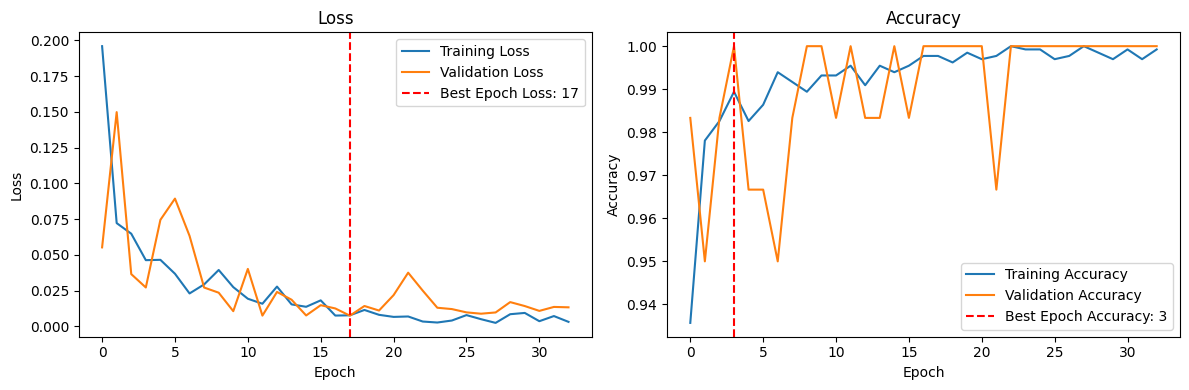

In [79]:
import matplotlib.pyplot as plt

# Plot training history for loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Mark the best epoch for validation loss
best_epoch_loss = np.argmin(history.history['val_loss'])
plt.axvline(x=best_epoch_loss, color='r', linestyle='--', label=f'Best Epoch Loss: {best_epoch_loss}')
plt.legend()

# Plot training history for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Mark the best epoch for validation accuracy
best_epoch_accuracy = np.argmax(history.history['val_accuracy'])
plt.axvline(x=best_epoch_accuracy, color='r', linestyle='--', label=f'Best Epoch Accuracy: {best_epoch_accuracy}')
plt.legend()

plt.tight_layout()
plt.show()

In [72]:
# Print the best epochs
print(f'Best Epoch for Validation Loss: {best_epoch_loss}')
print(f'Best Epoch for Validation Accuracy: {best_epoch_accuracy}')

Best Epoch for Validation Loss: 17
Best Epoch for Validation Accuracy: 3


# Model Testing and Evaluation

In [73]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation AUC: {val_auc}")

2/2 [==============================] - 14s 6s/step - loss: 0.0075 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation AUC: 1.0


In [78]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

5/5 [==============================] - 24s 5s/step - loss: 0.0876 - accuracy: 0.9733 - precision_2: 0.9733 - recall_2: 0.9733 - auc_2: 0.9956
Test Loss: 0.08757422864437103
Test Accuracy: 0.9733333587646484
Test Precision: 0.9733333587646484
Test Recall: 0.9733333587646484
Test AUC: 0.9956222176551819


In [76]:
def Prediction(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array((images[i].numpy()))
    img_array = tf.expand_dims(img_array,0)     # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    
    return predicted_class , confidence

Found 150 files belonging to 3 classes.


1/1 [==============================] - 0s 202ms/step


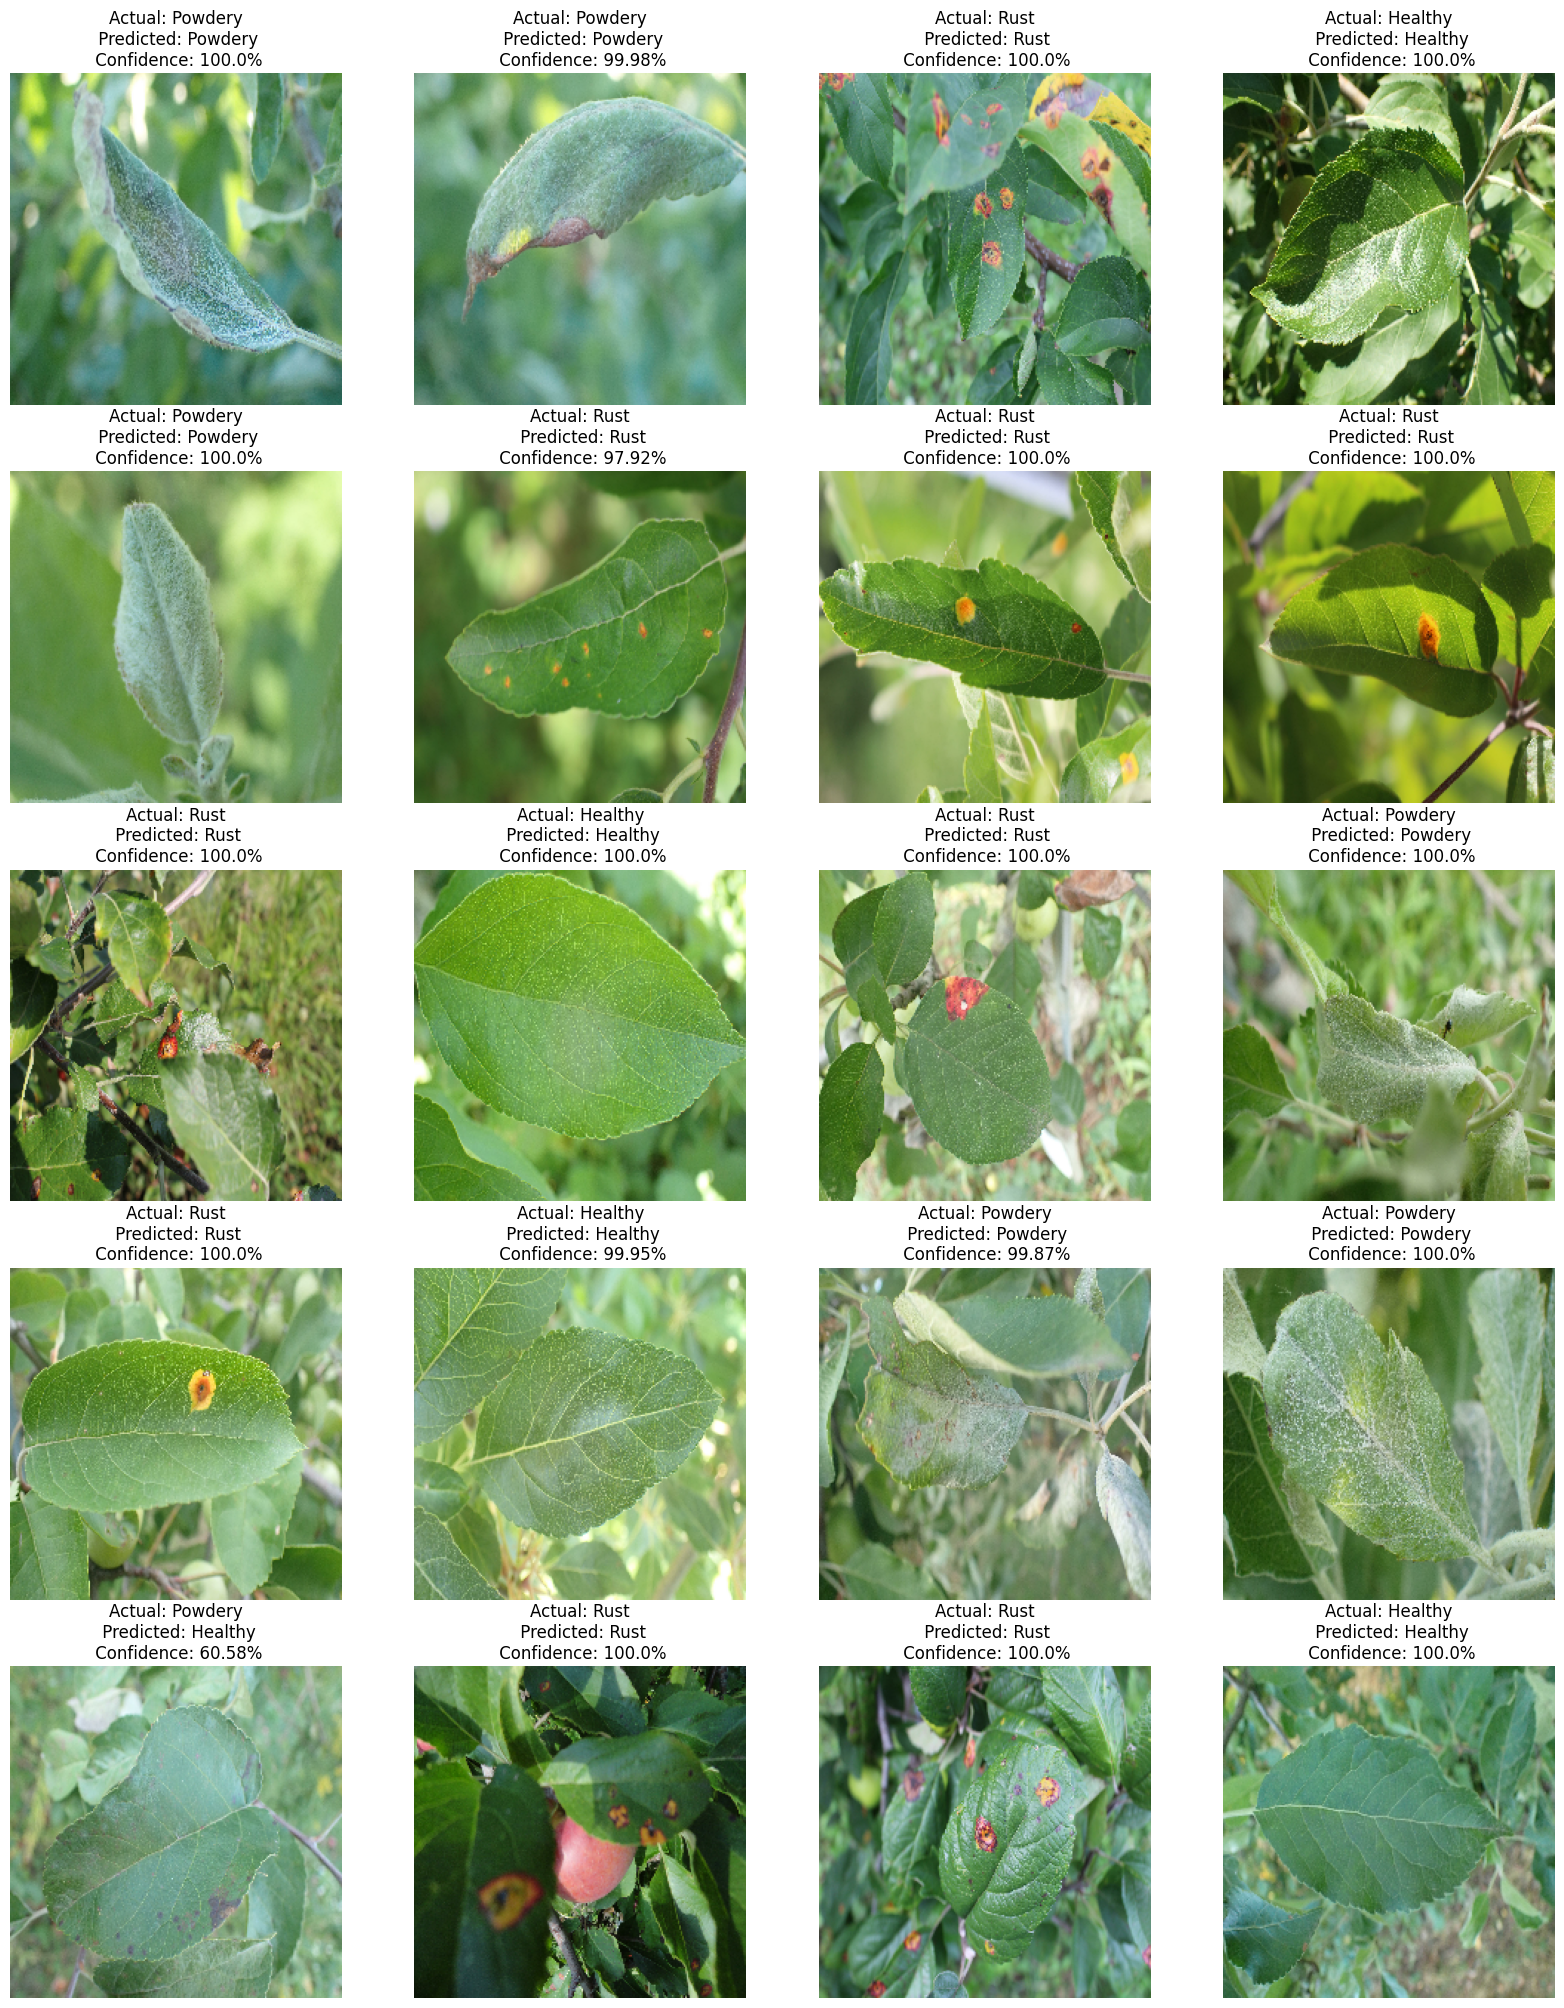

In [77]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Disease Recognition Dataset/Test",
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical',
)

plt.figure(figsize=(20, 25))
for images, labels in test_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Convert one-hot encoded label to an integer
        actual_class_index = np.argmax(labels[i])

        # Use the integer label to get the class name
        actual_class = class_names[actual_class_index]

        # Make predictions
        predicted_class, confidence = Prediction(model, images[i].numpy())

        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}%")
        plt.axis("off")
